In [87]:
pip install pyspark

In [88]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
spark = SparkSession.builder.appName("project").getOrCreate()

In [90]:
custom_schema=StructType([
StructField("id", IntegerType(), True),
StructField("title", StringType(), True),
StructField("vote_average", FloatType(), True),
StructField("vote_count", IntegerType(), True),
StructField("status", StringType(), True),
StructField("release_date", StringType(), True),
StructField("revenue", FloatType(), True),
StructField("runtime", FloatType(), True),
StructField("budget", FloatType(), True),
StructField("original_language", StringType(), True),
StructField("popularity", FloatType(), True),
StructField("genres", StringType(), True),
StructField("production_companies", StringType(), True),
StructField("production_countries", StringType(), True),
StructField("spoken_languages", StringType(), True)])

In [91]:
df_clean = spark.read.csv("/content/drive/MyDrive/Big Data/movies.csv", header=True, schema=custom_schema)
df_clean.show()

+------+--------------------+------------+----------+--------+------------+------------+-------+---------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+
|    id|               title|vote_average|vote_count|  status|release_date|     revenue|runtime|   budget|original_language|popularity|              genres|production_companies|production_countries|    spoken_languages|
+------+--------------------+------------+----------+--------+------------+------------+-------+---------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+
| 27205|           Inception|       8.364|     34495|Released|  15/07/2010| 8.2553274E8|  148.0|    1.6E8|               en|    83.952|Action, Science F...|Legendary Picture...|United Kingdom, U...|English, French, ...|
|157336|        Interstellar|       8.417|     32571|Released|   5/11/2014| 7.0172922E8|  169.0|   1.65E8|              

In [92]:
movies = df_clean # making a duplicate of initial dataset
print((movies.count(), len(movies.columns)))

df_clean.printSchema()
print((df_clean.count(), len(df_clean.columns)))

(395054, 15)
root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: float (nullable = true)
 |-- runtime: float (nullable = true)
 |-- budget: float (nullable = true)
 |-- original_language: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)

(395054, 15)


In [93]:
from pyspark.sql.functions import split, col, concat_ws, lpad, to_date

split_col = split(df_clean['release_date'], '/')

df_clean = df_clean.withColumn('release_day', split_col.getItem(0))
df_clean = df_clean.withColumn('release_month', split_col.getItem(1))
df_clean = df_clean.withColumn('release_year', split_col.getItem(2))

df_clean = df_clean.withColumn('release_day', lpad(col('release_day'), 2, '0'))
df_clean = df_clean.withColumn('release_month', lpad(col('release_month'), 2, '0'))

df_clean = df_clean.withColumn('formatted_release_date',
                               concat_ws('/', df_clean['release_day'], df_clean['release_month'], df_clean['release_year']))

df_clean = df_clean.withColumn('parsed_release_date', to_date('formatted_release_date', 'dd/MM/yyyy'))

columns_to_drop = ['release_date', 'release_day', 'release_month', 'release_year', 'formatted_release_date']

df_clean = df_clean.drop(*columns_to_drop)


df_clean.show()
print((df_clean.count(), len(df_clean.columns)))

+------+--------------------+------------+----------+--------+------------+-------+---------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+-------------------+
|    id|               title|vote_average|vote_count|  status|     revenue|runtime|   budget|original_language|popularity|              genres|production_companies|production_countries|    spoken_languages|parsed_release_date|
+------+--------------------+------------+----------+--------+------------+-------+---------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+-------------------+
| 27205|           Inception|       8.364|     34495|Released| 8.2553274E8|  148.0|    1.6E8|               en|    83.952|Action, Science F...|Legendary Picture...|United Kingdom, U...|English, French, ...|         2010-07-15|
|157336|        Interstellar|       8.417|     32571|Released| 7.0172922E8|  169.0|   1.65E8

In [94]:
from pyspark.sql.functions import when, round, col

# Seting values to None if they are 0
df_clean = df_clean.withColumn("budget", when(df_clean["budget"] == 0, None).otherwise(df_clean["budget"]))
df_clean = df_clean.withColumn("popularity", when(df_clean["popularity"] == 0, None).otherwise(df_clean["popularity"]))
df_clean = df_clean.withColumn("revenue", when(df_clean["revenue"] == 0, None).otherwise(df_clean["revenue"]))
df_clean = df_clean.withColumn("runtime", when(df_clean["runtime"] == 0, None).otherwise(df_clean["runtime"]))
df_clean = df_clean.withColumn("vote_average", when(df_clean["vote_average"] == 0, None).otherwise(df_clean["vote_average"]))

# Round columns
df_clean = df_clean.withColumn("revenue", round(col("revenue"), 2))
df_clean = df_clean.withColumn("runtime", round(col("runtime"), 2))
df_clean = df_clean.withColumn("budget", round(col("budget"), 2))
df_clean = df_clean.withColumn("popularity", round(col("popularity"), 2))
df_clean = df_clean.withColumn("vote_average", round(col("vote_average"), 2))

df  = df_clean
# df is needed to understand the difference with missing and without missing values datasets

df_clean.show()

+------+--------------------+------------+----------+--------+------------+-------+---------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+-------------------+
|    id|               title|vote_average|vote_count|  status|     revenue|runtime|   budget|original_language|popularity|              genres|production_companies|production_countries|    spoken_languages|parsed_release_date|
+------+--------------------+------------+----------+--------+------------+-------+---------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+-------------------+
| 27205|           Inception|        8.36|     34495|Released| 8.2553274E8|  148.0|    1.6E8|               en|     83.95|Action, Science F...|Legendary Picture...|United Kingdom, U...|English, French, ...|         2010-07-15|
|157336|        Interstellar|        8.42|     32571|Released| 7.0172922E8|  169.0|   1.65E8

In [96]:
missing_counts = df_clean.select([col(column).isNull().cast('int').alias(column) for column in df_clean.columns]) \
                   .agg(*[F.sum(column).alias(column) for column in df_clean.columns]) \
                   .toPandas()

print(missing_counts)

   id  title  vote_average  vote_count  status  revenue  runtime  budget  \
0   0      1         49390           8       1   378256    61068  366514   

   original_language  popularity  genres  production_companies  \
0                  1       11874   82746                150303   

   production_countries  spoken_languages  parsed_release_date  
0                103426             89945                19128  


In [97]:
# as it is not a scientific dataset, i decided to remove all NULLs
# the null values after duplicates to have a clear view
for col_name in df_clean.columns:
    df_clean = df_clean.withColumn(col_name, when(col(col_name) == '', None).otherwise(col(col_name)))
df_clean = df_clean.na.drop()
df_clean.show()
print((df_clean.count(), len(df_clean.columns)))

+------+--------------------+------------+----------+--------+------------+-------+---------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+-------------------+
|    id|               title|vote_average|vote_count|  status|     revenue|runtime|   budget|original_language|popularity|              genres|production_companies|production_countries|    spoken_languages|parsed_release_date|
+------+--------------------+------------+----------+--------+------------+-------+---------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+-------------------+
| 27205|           Inception|        8.36|     34495|Released| 8.2553274E8|  148.0|    1.6E8|               en|     83.95|Action, Science F...|Legendary Picture...|United Kingdom, U...|English, French, ...|         2010-07-15|
|157336|        Interstellar|        8.42|     32571|Released| 7.0172922E8|  169.0|   1.65E8

In [98]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def count_languages(language):
    spoken_languages = language.split(', ')
    return len(spoken_languages)

def count_companies(companies):
    companies_list = companies.split(', ')
    return len(companies_list)

def count_genres(genres):
    genre_list = genres.split(', ')
    return len(genre_list)

def count_countries(countries):
    country_list = countries.split(', ')
    return len(country_list)

# Register the UDFs
count_languages_udf = udf(count_languages, IntegerType())
count_companies_list = udf(count_companies, IntegerType())
count_genres_udf = udf(count_genres, IntegerType())
count_countries_udf = udf(count_countries, IntegerType())

# Apply the UDFs to the respective columns in df_clean
df_clean = df_clean.withColumn("spoken_languages_count", count_languages_udf(df_clean["spoken_languages"]))
df_clean = df_clean.withColumn("companies_count", count_companies_list(df_clean["production_companies"]))
df_clean = df_clean.withColumn("genres_count", count_genres_udf(df_clean["genres"]))
df_clean = df_clean.withColumn("countries_count", count_countries_udf(df_clean["production_countries"]))


df_clean.show()

+------+--------------------+------------+----------+--------+------------+-------+---------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+-------------------+----------------------+---------------+------------+---------------+
|    id|               title|vote_average|vote_count|  status|     revenue|runtime|   budget|original_language|popularity|              genres|production_companies|production_countries|    spoken_languages|parsed_release_date|spoken_languages_count|companies_count|genres_count|countries_count|
+------+--------------------+------------+----------+--------+------------+-------+---------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+-------------------+----------------------+---------------+------------+---------------+
| 27205|           Inception|        8.36|     34495|Released| 8.2553274E8|  148.0|    1.6E8|               en|    

In [99]:
from pyspark.sql.functions import split, col

# Extract the main genre, company, country, and language
df_clean = df_clean.withColumn("main_genre", split(col("genres"), ",")[0])
df_clean = df_clean.withColumn("main_company", split(col("production_companies"), ",")[0])
df_clean = df_clean.withColumn("main_country", split(col("production_countries"), ",")[0])
df_clean = df_clean.withColumn("main_language", split(col("spoken_languages"), ",")[0])

# Specify the columns you want to drop
columns_to_drop = ['genres', 'production_companies', 'production_countries', 'spoken_languages']

# Drop the specified columns
df_clean = df_clean.drop(*columns_to_drop)

# Show the DataFrame
df_clean.show()

+------+--------------------+------------+----------+--------+------------+-------+---------+-----------------+----------+-------------------+----------------------+---------------+------------+---------------+---------------+--------------------+--------------------+-------------+
|    id|               title|vote_average|vote_count|  status|     revenue|runtime|   budget|original_language|popularity|parsed_release_date|spoken_languages_count|companies_count|genres_count|countries_count|     main_genre|        main_company|        main_country|main_language|
+------+--------------------+------------+----------+--------+------------+-------+---------+-----------------+----------+-------------------+----------------------+---------------+------------+---------------+---------------+--------------------+--------------------+-------------+
| 27205|           Inception|        8.36|     34495|Released| 8.2553274E8|  148.0|    1.6E8|               en|     83.95|         2010-07-15|         

In [100]:
df_clean = df_clean.withColumn("movie_type",
                   when(col("runtime") < 45, "Short movie")
                   .otherwise("Long movie"))

In [ ]:
# there are movie budgets and revenues that are very small ( < 100000 ) so it will be removed from the start


In [101]:
df_distinct = df_clean.dropDuplicates(['title'])
print((df_distinct.count(), len(df_distinct.columns)))
df_distinct.show()
df = df_distinct
print((df.count(), len(df.columns)))

(9304, 20)
+-------+--------------------+------------+----------+--------+------------+-------+---------+-----------------+----------+-------------------+----------------------+---------------+------------+---------------+---------------+--------------------+--------------------+-------------+-----------+
|     id|               title|vote_average|vote_count|  status|     revenue|runtime|   budget|original_language|popularity|parsed_release_date|spoken_languages_count|companies_count|genres_count|countries_count|     main_genre|        main_company|        main_country|main_language| movie_type|
+-------+--------------------+------------+----------+--------+------------+-------+---------+-----------------+----------+-------------------+----------------------+---------------+------------+---------------+---------------+--------------------+--------------------+-------------+-----------+
| 516517|"Beyond Wrestling...|         9.0|         2|Released|      7764.0|  110.0|   9888.0|       

In [102]:
df =  df.filter(df['budget'] > 100000)
df =  df.filter(df['revenue'] > 100000)
print((df.count(), len(df.columns)))

(8425, 20)


In [103]:
df = df.withColumn('profit', F.col('revenue') - F.col('budget'))

df = df.withColumn('profit_or_loss', F.when(df['profit'] > 0, 'Profit').otherwise('Loss'))


In [104]:
pandas_df  = df.toPandas()
pandas_df.isna().sum()

id                        0
title                     0
vote_average              0
vote_count                0
status                    0
revenue                   0
runtime                   0
budget                    0
original_language         0
popularity                0
parsed_release_date       0
spoken_languages_count    0
companies_count           0
genres_count              0
countries_count           0
main_genre                0
main_company              0
main_country              0
main_language             0
movie_type                0
profit                    0
profit_or_loss            0
dtype: int64

In [ ]:
spark.stop()

In [ ]:
pandas_df.to_csv("/content/drive/MyDrive/Big Data/movies_out_noNULL.csv", index=False, header=True)
import shutil

shutil.rmtree('//content/drive/MyDrive/Big Data/movies_out_noNULL.csv', ignore_errors=True)

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

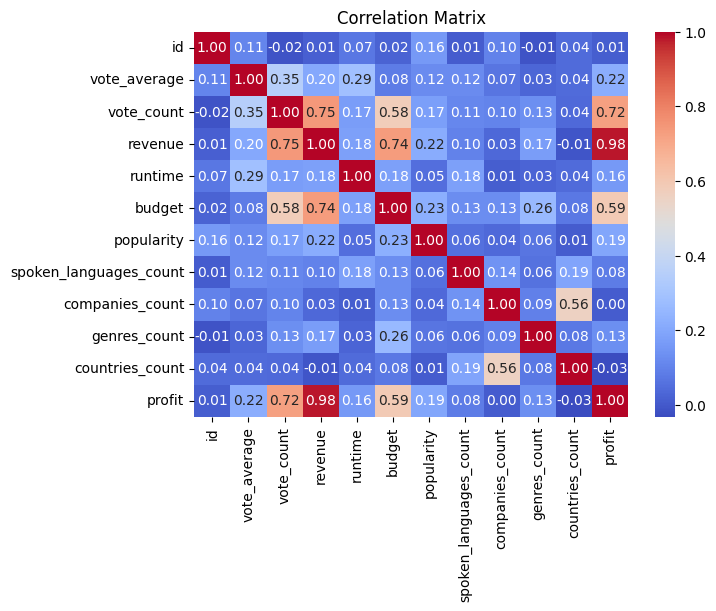

In [106]:
correlation_matrix = pandas_df.corr(numeric_only=True)

plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

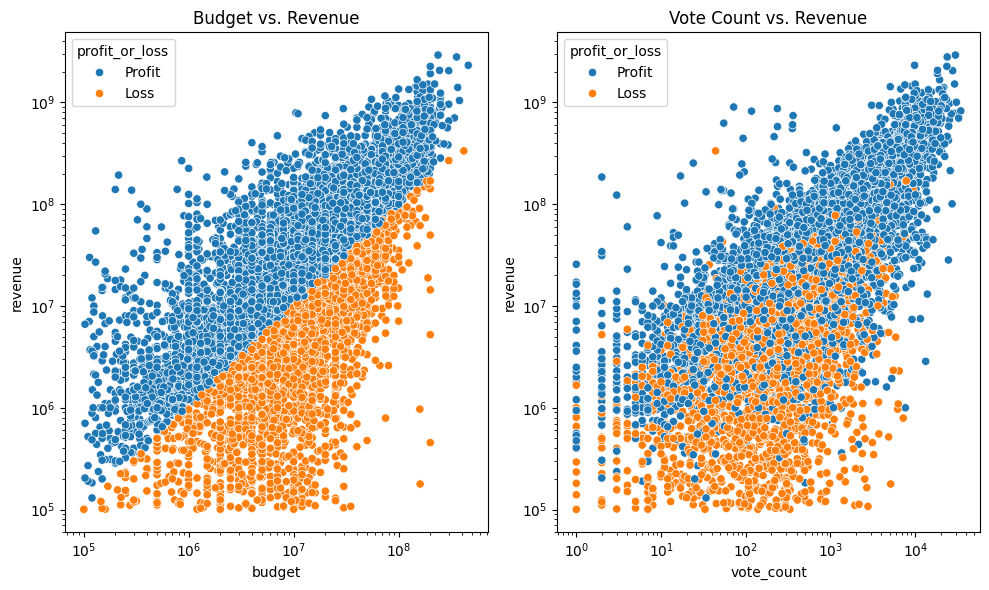

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Scatter plot for budget vs. revenue
sns.scatterplot(data=pandas_df, x='budget', y='revenue', hue = 'profit_or_loss', ax=axes[0])
axes[0].set_title('Budget vs. Revenue')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Scatter plot for vote_count vs. revenue
sns.scatterplot(data=pandas_df, x='vote_count', y='revenue', hue = 'profit_or_loss', ax=axes[1])
axes[1].set_title('Vote Count vs. Revenue')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

In [ ]:
df.createOrReplaceTempView('df')

In [ ]:
df.describe().show()

+-------+-----------------+--------------------+------------------+------------------+--------------------+--------------------+-----------------+--------------------+-----------------+------------------+------------------+--------------------+--------------------+--------------------+
|summary|               id|               title|      vote_average|        vote_count|              status|             revenue|          runtime|              budget|original_language|        popularity|            genres|production_companies|production_countries|    spoken_languages|
+-------+-----------------+--------------------+------------------+------------------+--------------------+--------------------+-----------------+--------------------+-----------------+------------------+------------------+--------------------+--------------------+--------------------+
|  count|           395054|              395053|            345664|            395046|              395053|               16798|           

In [ ]:

summary_stats_revenue = df.select(
    round(mean(df['revenue']), 2).alias('mean'),
    round(median(df['revenue']), 2).alias('median'),
    round(min(df['revenue']), 2).alias('min'),
    round(max(df['revenue']), 2).alias('max'),
    round(stddev(df['revenue']), 2).alias('stddev'),
    round(variance(df['revenue']), 2).alias('variance'),
    round(expr('percentile(revenue, 0.25)'), 2).alias('quantile_1'),
    round(expr('percentile(revenue, 0.75)'), 2).alias('quantile_3')
)


# Display results
print("Summary Statistics for 'revenue' column:")
summary_stats_revenue.show()

summary_stats_budget = df.select(
    round(mean(df['budget']), 2).alias('mean'),
    round(median(df['budget']), 2).alias('median'),
    round(min(df['budget']), 2).alias('min'),
    round(max(df['budget']), 2).alias('max'),
    round(stddev(df['budget']), 2).alias('stddev'),
    round(variance(df['budget']), 2).alias('variance'),
    round(expr('percentile(budget, 0.25)'), 2).alias('quantile_1'),
    round(expr('percentile(budget, 0.75)'), 2).alias('quantile_3')
)
print("Summary Statistics for 'budget' column:")
summary_stats_budget.show()


summary_stats_vote_count = df.select(
    round(mean(df['vote_count']), 2).alias('mean'),
    round(median(df['vote_count']), 2).alias('median'),
    round(min(df['vote_count']), 2).alias('min'),
    round(max(df['vote_count']), 2).alias('max'),
    round(stddev(df['vote_count']), 2).alias('stddev'),
    round(variance(df['vote_count']), 2).alias('variance'),
    round(expr('percentile(vote_count, 0.25)'), 2).alias('quantile_1'),
    round(expr('percentile(vote_count, 0.75)'), 2).alias('quantile_3')
)

print("Summary Statistics for 'vote_count' column:")
summary_stats_vote_count.show()



Summary Statistics for 'revenue' column:
+-------------+----------+--------+------------+--------------+--------------------+----------+----------+
|         mean|    median|     min|         max|        stddev|            variance|quantile_1|quantile_3|
+-------------+----------+--------+------------+--------------+--------------------+----------+----------+
|7.708550979E7|1.950404E7|100270.0|2.92370611E9|1.6583122144E8|2.749999400406484E16| 4396821.0|7.318072E7|
+-------------+----------+--------+------------+--------------+--------------------+----------+----------+

Summary Statistics for 'budget' column:
+-------------+------+--------+-----+-------------+--------------------+----------+----------+
|         mean|median|     min|  max|       stddev|            variance|quantile_1|quantile_3|
+-------------+------+--------+-----+-------------+--------------------+----------+----------+
|2.715674427E7| 1.3E7|100270.0|4.6E8|3.970088603E7|1.576160351814103...| 4000000.0|     3.2E7|
+--

In [ ]:
spark.sql('''
select movie_type, avg(revenue), avg(budget), sum(vote_count) from df
group by movie_type
''').show()

# average revenue for long movies are 77,000,000
# and almost 10 times more than for short movies whish is 8,000,000

# avg budget for short movies is 2,500,000
# avg budget for long movie is 27,000,000
# again 10 times more

+-----------+------------------+-------------------+---------------+
| movie_type|      avg(revenue)|        avg(budget)|sum(vote_count)|
+-----------+------------------+-------------------+---------------+
|Short movie| 8050181.615384615| 2479653.4615384615|           1304|
| Long movie|7.71921977660485E7|2.719488052686638E7|       14927534|
+-----------+------------------+-------------------+---------------+



In [ ]:
spark.sql('''
select * from df
where revenue <0 or budget < 0 or popularity < 0
''').count()

# checking if there are negative values

0

In [ ]:
spark.sql('''
select count(main_company), avg(revenue), main_company
from df
group by main_company
order by count(main_company) DESC
''').show()

spark.sql('''
select count(main_genre), avg(revenue), main_genre
from df
group by main_genre
order by count(main_genre) DESC
''').show()

spark.sql('''
select count(main_country), avg(revenue), main_country
from df
group by main_country
order by count(main_country) DESC
''').show()

+-------------------+--------------------+--------------------+
|count(main_company)|        avg(revenue)|        main_company|
+-------------------+--------------------+--------------------+
|                292|1.1786393267465754E8|           Paramount|
|                284|1.1862487733098592E8|  Universal Pictures|
|                202|1.2473597038613862E8|   Columbia Pictures|
|                170|1.4667928234705883E8|Warner Bros. Pict...|
|                160|    2.286041999375E7| Metro-Goldwyn-Mayer|
|                134|1.0393153558955224E8|     New Line Cinema|
|                121| 2.695933358512397E8|Walt Disney Pictures|
|                115| 8.427451827826087E7|    20th Century Fox|
|                 93| 9.217225987096775E7| Touchstone Pictures|
|                 68|5.3905332176470585E7|      United Artists|
|                 66| 5.265906477272727E7|    TriStar Pictures|
|                 59| 6.121018689830509E7|             Miramax|
|                 48|2.7532095145833332E

In [ ]:
spark.sql('''
select count(main_company), avg(revenue), main_company
from df
group by main_company
order by avg(revenue) DESC
''').show()


spark.sql('''
select count(main_genre), avg(revenue), main_genre
from df
group by main_genre
order by avg(revenue) DESC
''').show()

spark.sql('''
select count(main_country), avg(revenue), main_country
from df
group by main_country
order by avg(revenue) DESC
''').show()

+-------------------+-------------------+--------------------+
|count(main_company)|       avg(revenue)|        main_company|
+-------------------+-------------------+--------------------+
|                  2|      1.007370624E9|             Syncopy|
|                 32|      9.230105795E8|      Marvel Studios|
|                  1|       9.02540928E8|August 1st Film S...|
|                  1|        8.9498336E8|Laura Ziskin Prod...|
|                  1|       8.70322688E8|Spring Era Film C...|
|                  1|        8.5608512E8|Matt Tolmach Prod...|
|                  1|       8.22049664E8|Alibaba Pictures ...|
|                  1|        7.8589664E8|      Maximum Effort|
|                  1|         7.709456E8|         6th & Idaho|
|                  1|       7.60099008E8|Chris Morgan Prod...|
|                  2|        7.4124216E8|LuckyChap Enterta...|
|                  8|       7.36857944E8|        Illumination|
|                  1|       7.23192704E8|    Esperanto 

In [ ]:

spark.sql('''
    SELECT
        original_language,
        COUNT(original_language) AS language_count,
        ROUND((COUNT(original_language) * 100.0) / (SELECT COUNT(*) FROM df), 3) AS language_percentage
    FROM
        df
    GROUP BY
        original_language
    ORDER BY
        language_count DESC
''').show()

# most movies are in english
spark.sql('''
    SELECT
        main_genre,
        COUNT(main_genre) AS N_main_genre,
        ROUND((COUNT(main_genre) * 100.0) / (SELECT COUNT(*) FROM df), 3) AS Percent_main_genre
    FROM
        df
    GROUP BY
        main_genre
    ORDER BY
        N_main_genre DESC
''').show()


+-----------------+--------------+-------------------+
|original_language|language_count|language_percentage|
+-----------------+--------------+-------------------+
|               en|          6701|             79.537|
|               hi|           274|              3.252|
|               fr|           258|              3.062|
|               ru|           160|              1.899|
|               es|           134|              1.591|
|               ja|            94|              1.116|
|               ta|            83|              0.985|
|               zh|            81|              0.961|
|               it|            74|              0.878|
|               ko|            72|              0.855|
|               ml|            69|              0.819|
|               de|            51|              0.605|
|               te|            47|              0.558|
|               cn|            39|              0.463|
|               no|            24|              0.285|
|         

In [ ]:


spark.sql('''
select count(status), status from df
group by status''').show()



+-------------+--------+
|count(status)|  status|
+-------------+--------+
|         8425|Released|
+-------------+--------+



In [ ]:
spark.sql('''
select profit, title
from df
order by profit DESC
limit 10
''').show()

+------------+--------------------+
|      profit|               title|
+------------+--------------------+
|2.68670618E9|              Avatar|
|     2.444E9|   Avengers: Endgame|
| 2.0641623E9|             Titanic|
|1.86025037E9|Avatar: The Way o...|
|1.82322355E9|Star Wars: The Fo...|
|1.75241498E9|Avengers: Infinit...|
|1.72184717E9|Spider-Man: No Wa...|
|1.52153741E9|      Jurassic World|
|1.32534144E9|           Furious 7|
| 1.3187328E9|   Top Gun: Maverick|
+------------+--------------------+



In [ ]:
spark.sql('''
select sum(profit), genres_count
from df
group by genres_count
order by sum(profit) desc
''').show()

spark.sql('''
select sum(profit), companies_count
from df
group by companies_count
order by sum(profit) desc
''').show()

spark.sql('''
select sum(profit), countries_count
from df
group by countries_count
order by sum(profit) desc
''').show()

+----------------+------------+
|     sum(profit)|genres_count|
+----------------+------------+
|1.98295448157E11|           3|
| 9.6673488206E10|           2|
| 7.2467782941E10|           4|
| 2.7822057494E10|           1|
| 2.2055826135E10|           5|
|   3.332565885E9|           6|
|       2680800.0|           7|
+----------------+------------+

+----------------+---------------+
|     sum(profit)|companies_count|
+----------------+---------------+
|1.12146198443E11|              2|
|1.01930467157E11|              3|
| 6.8869820373E10|              4|
| 5.1976379042E10|              1|
| 3.7775801509E10|              5|
| 2.2410336583E10|              6|
| 1.2399297109E10|              7|
|   6.943727365E9|              8|
|   3.770049472E9|              9|
|   1.099878269E9|             10|
|    6.29426804E8|             11|
|    5.90067811E8|             13|
|    1.17369464E8|             17|
|     4.8289792E7|             15|
|     2.6083327E7|             12|
|     2.4544109E7

In [ ]:
# ML models

In [ ]:
pandas_df.head()

,id,title,vote_average,vote_count,status,revenue,runtime,budget,original_language,popularity,...,companies_count,genres_count,countries_count,main_genre,main_company,main_country,main_language,movie_type,profit,profit_or_loss
0,614696,#Alive,7.28,1570,Released,13416285.0,98.0,6300000.0,ko,24.120001,...,3,4,1,Horror,Lotte Entertainment,South Korea,Korean,Long movie,7116285.0,Profit
1,19913,(500) Days of Summer,7.27,9359,Released,60781544.0,95.0,7500000.0,en,33.310001,...,3,3,1,Comedy,Fox Searchlight Pictures,United States of America,English,Long movie,53281544.0,Profit
2,9805,(T)Raumschiff Surprise - Periode 1,6.20,457,Released,76341400.0,87.0,9000000.0,de,10.330000,...,2,2,1,Comedy,herbX Film,Germany,German,Long movie,67341400.0,Profit
3,576987,(UN)Ideal Man,5.60,17,Released,8613317.0,89.0,1839363.0,ru,2.120000,...,3,3,1,Comedy,Non-Stop Productions,Russia,Russian,Long movie,6773954.0,Profit
4,11548,*batteries not included,6.60,623,Released,65088796.0,106.0,25000000.0,en,16.930000,...,2,4,1,Science Fiction,Amblin Entertainment,United States of America,English,Long movie,40088796.0,Profit


In [108]:
pandas_df['profit_or_loss'] = pandas_df['profit_or_loss'].replace({'Profit': 1, 'Loss': 0})

In [109]:
X = pandas_df[['vote_average', 'vote_count', 'runtime', 'popularity', 'spoken_languages_count', 'countries_count', 'companies_count']].values

# Selecting y target variable
y = pandas_df.iloc[:, -1].values

In [110]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [111]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [112]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_test)

accuracy_1 = accuracy_score(y_test, y_pred_logistic)

# Confusion Matrix
cm_1 = confusion_matrix(y_test, y_pred_logistic)


print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.63      0.28      0.39       521
           1       0.74      0.93      0.82      1164

    accuracy                           0.73      1685
   macro avg       0.69      0.60      0.61      1685
weighted avg       0.71      0.73      0.69      1685



In [113]:
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model on the training set
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions on the training and testing sets
y_train_pred = logistic_model.predict(X_train)
y_test_pred = logistic_model.predict(X_test)

# Calculate accuracy scores
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print the accuracy scores
print("F1 Scores:")
print(f"Training F1: {train_f1*100:.2f}%")
print(f"Testing F1: {test_f1*100:.2f}%")

# Check for overfitting
if train_f1 > test_f1:
    print("The model might be overfitting the training data.")
else:
    print("The model is performing well on both training and testing data.")

F1 Scores:
Training F1: 82.17%
Testing F1: 82.10%
The model might be overfitting the training data.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [114]:
#chekcing if it is overfitting
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# Predictions on training and test sets
y_train_pred = logistic_model.predict(X_train)
y_test_pred = logistic_model.predict(X_test)

# Calculate evaluation metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print initial model metrics
print("Initial Model Metrics:")
print(f"Training Accuracy: {train_accuracy*100}")
print(f"Testing Accuracy: {test_accuracy*100}")
print(f"Training Precision: {train_precision*100}")
print(f"Testing Precision: {test_precision*100}")
print(f"Training Recall: {train_recall*100}")
print(f"Testing Recall: {test_recall*100}")
print(f"Training F1 Score: {train_f1*100}")
print(f"Testing F1 Score: {test_f1*100}")

# Check for overfitting based on F1 scores
if train_f1 > test_f1:
    print("The initial model might be overfitting based on F1 score but the diffrence is too small.")
else:
    print("The initial model is not overfitting based on F1 score.")

if train_accuracy > test_accuracy:
    print("The initial model might be overfitting based on accuracy score but the diffrence is too small.")
else:
    print("The initial model is not overfitting based on accuracy score.")

Initial Model Metrics:
Training Accuracy: 71.973293768546
Testing Accuracy: 71.6320474777448
Training Precision: 72.73942838041117
Testing Precision: 72.77556440903055
Training Recall: 94.40347071583514
Testing Recall: 94.15807560137456
Training F1 Score: 82.16746908335693
Testing F1 Score: 82.09737827715357
The initial model might be overfitting based on F1 score but the diffrence is too small.
The initial model might be overfitting based on accuracy score but the diffrence is too small.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


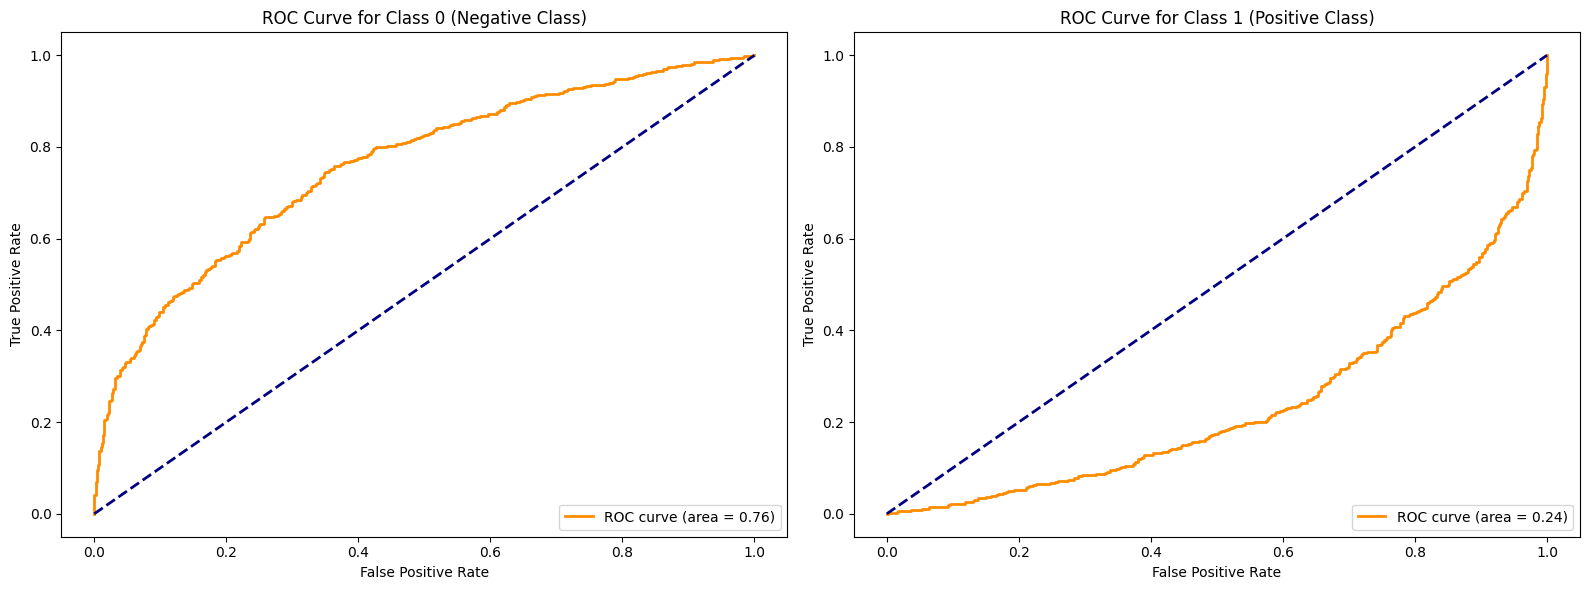

In [115]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


y_prob_0 = logistic_model.predict_proba(X_test)[:, 1]  # Probability of class 0
y_prob_1 = logistic_model.predict_proba(X_test)[:, 0]  # Probability of class 1

# ROC curve for class 0
fpr_0, tpr_0, thresholds_0 = roc_curve(y_test, y_prob_0)
roc_auc_0 = auc(fpr_0, tpr_0)

# ROC curve for class 1
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_prob_1)
roc_auc_1 = auc(fpr_1, tpr_1)

# Plot both ROC curves side by side
plt.figure(figsize=(16, 6))

# ROC curve for class 0
plt.subplot(1, 2, 1)
plt.plot(fpr_0, tpr_0, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_0:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Class 0 (Negative Class)')
plt.legend(loc='lower right')

# ROC curve for class 1
plt.subplot(1, 2, 2)
plt.plot(fpr_1, tpr_1, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Class 1 (Positive Class)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

Cross-validation scores: [0.81552468 0.81350954 0.82585625 0.82596154 0.82165297]
Mean cross-validation F1 score: 0.8205009958506718

Training F1 Score: 0.8210526315789474
Testing F1 Score: 0.8240244835501147

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.28      0.39       521
           1       0.74      0.93      0.82      1164

    accuracy                           0.73      1685
   macro avg       0.69      0.60      0.61      1685
weighted avg       0.71      0.73      0.69      1685



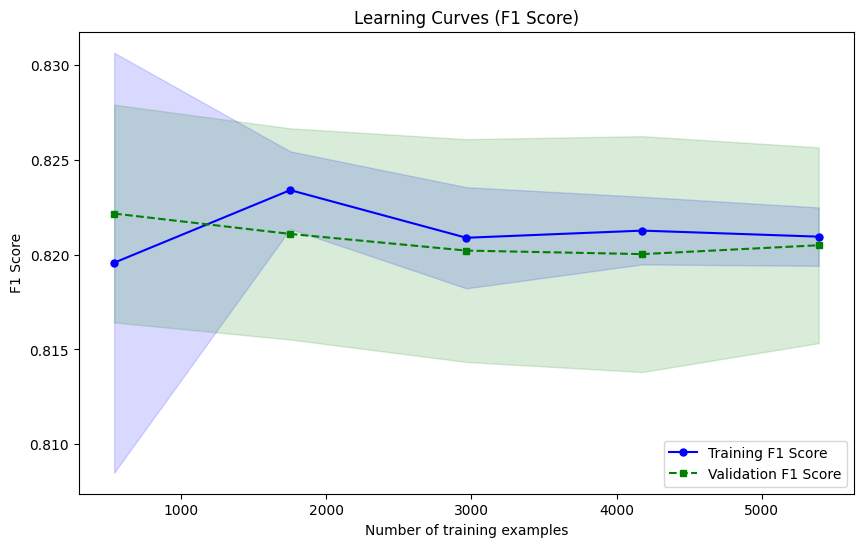

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Import necessary libraries
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize logistic regression model
log_reg_model = LogisticRegression()

# Cross-validation to evaluate model
cv_scores = cross_val_score(log_reg_model, X_train, y_train, cv=5, scoring='f1')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation F1 score:", np.mean(cv_scores))

# Fit the model
log_reg_model.fit(X_train, y_train)

# Predictions on training and testing sets
train_predictions = log_reg_model.predict(X_train)
test_predictions = log_reg_model.predict(X_test)

# Evaluate performance using F1 score
train_f1_score = f1_score(y_train, train_predictions)
test_f1_score = f1_score(y_test, test_predictions)

print("\nTraining F1 Score:", train_f1_score)
print("Testing F1 Score:", test_f1_score)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, test_predictions))

# Plot learning curves
train_sizes, train_scores, test_scores = learning_curve(log_reg_model, X_train, y_train, cv=5, scoring='f1')
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training F1 Score')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation F1 Score')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of training examples')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')
plt.title('Learning Curves (F1 Score)')
plt.show()

# Assess for overfitting:
# - If the training accuracy is significantly higher than the testing accuracy, it suggests potential overfitting.
# - If the gap between the training and validation accuracies remains large as the number of training examples increases, it also suggests overfitting.
# Depending on the assessment:
# - Consider regularization techniques like L1 or L2 regularization.
# - Evaluate feature selection/elimination.
# - Experiment with different algorithms or model architectures.
# - Collect more data if feasible to improve generalization.


In [117]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy import stats
from statsmodels.compat import lzip
import statsmodels

In [118]:
# Add a constant term for the intercept
X = pandas_df[['vote_average', 'vote_count', 'runtime', 'popularity', 'spoken_languages_count', 'countries_count', 'companies_count']].values

# Selecting y target variable
y = pandas_df['profit']

In [119]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [120]:
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                 profit   R-squared (uncentered):                   0.599
Model:                            OLS   Adj. R-squared (uncentered):              0.599
Method:                 Least Squares   F-statistic:                              1439.
Date:                Mon, 01 Apr 2024   Prob (F-statistic):                        0.00
Time:                        11:27:50   Log-Likelihood:                     -1.3342e+05
No. Observations:                6740   AIC:                                  2.669e+05
Df Residuals:                    6733   BIC:                                  2.669e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

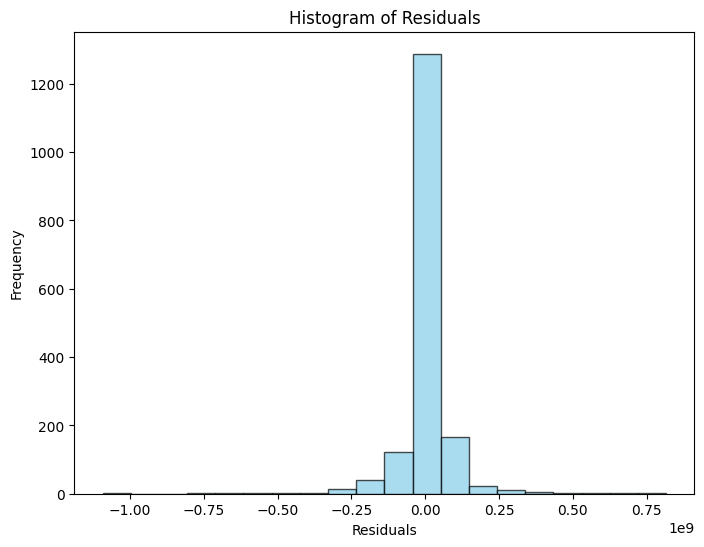

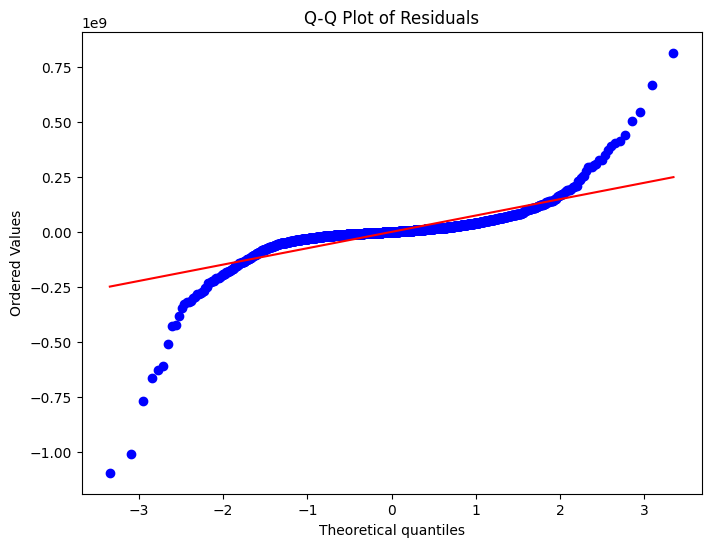

Shapiro-Wilk Test - Statistic: 0.6543893218040466, p-value: 0.0
Residuals are not normally distributed (reject H0)


In [121]:
residuals = model.predict(X_test) - y_test


plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Q-Q plot of residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Shapiro-Wilk test
statistic, p_value = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test - Statistic: {statistic}, p-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value > alpha:
    print("Residuals are normally distributed (fail to reject H0)")
else:
    print("Residuals are not normally distributed (reject H0)")

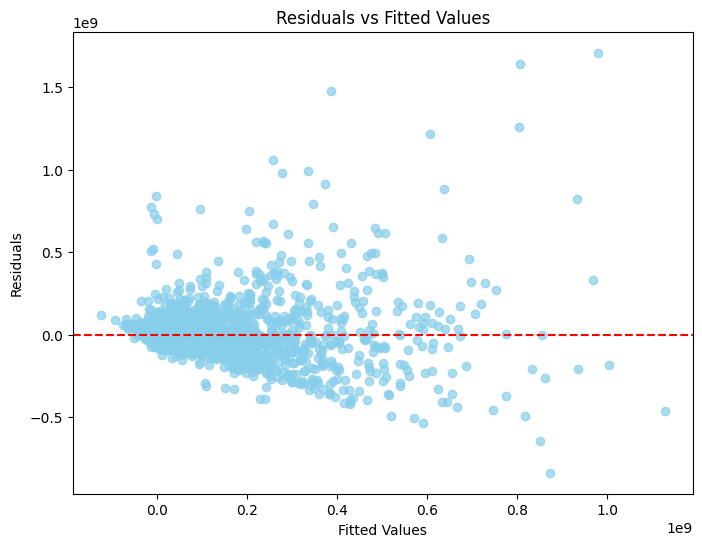

In [122]:
fitted_values = model.fittedvalues

# Compute residuals
residuals = model.resid

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, color='skyblue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

In [123]:

from scipy.stats import ttest_ind
pandas_df['parsed_release_date'] = pd.to_datetime(pandas_df['parsed_release_date'])
pandas_df['release_year'] = pandas_df['parsed_release_date'].dt.year
# Assuming 'release_year' is a column representing the year
# of release in your DataFrame
group_a = pandas_df[pandas_df['release_year'] == 2019]
group_b = pandas_df[pandas_df['release_year'] == 2020]



# Perform t-test
t_stat, p_value = ttest_ind(group_a['profit'], group_b['profit'], equal_var=False)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between groups A and B.")
else:
    print("There is no significant difference between groups A and B.")

There is a significant difference between groups A and B.


In [ ]:

from scipy.stats import ttest_ind
pandas_df['parsed_release_date'] = pd.to_datetime(pandas_df['parsed_release_date'])
pandas_df['release_year'] = pandas_df['parsed_release_date'].dt.year
# Assuming 'release_year' is a column representing the year
# of release in your DataFrame

group_a = pandas_df[(pandas_df['release_year'] == 2019) & (pandas_df['main_country'] == 'Russia')]
group_b = pandas_df[(pandas_df['release_year'] == 2019) & (pandas_df['main_country'] == 'United States of America')]



# Perform t-test
t_stat, p_value = ttest_ind(group_a['profit'], group_b['profit'], equal_var=False)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between groups A and B.")
else:
    print("There is no significant difference between groups A and B.")

There is a significant difference between groups A and B.


In [ ]:

from scipy.stats import ttest_ind
pandas_df['parsed_release_date'] = pd.to_datetime(pandas_df['parsed_release_date'])
pandas_df['release_year'] = pandas_df['parsed_release_date'].dt.year
# Assuming 'release_year' is a column representing the year
# of release in your DataFrame

group_a = pandas_df[(pandas_df['release_year'] == 2023) & (pandas_df['main_genre'] == 'Documentary')]
group_b = pandas_df[(pandas_df['release_year'] == 2023) & (pandas_df['main_genre'] == 'Drama')]



# Perform t-test
t_stat, p_value = ttest_ind(group_a['profit'], group_b['profit'], equal_var=False)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between groups A and B.")
else:
    print("There is no significant difference between groups A and B.")

There is no significant difference between groups A and B.


In [ ]:

from scipy.stats import ttest_ind
pandas_df['parsed_release_date'] = pd.to_datetime(pandas_df['parsed_release_date'])
pandas_df['release_year'] = pandas_df['parsed_release_date'].dt.year
# Assuming 'release_year' is a column representing the year
# of release in your DataFrame

group_a = pandas_df[(pandas_df['release_year'] == 2018) & (pandas_df['main_company'] == 'Marvel Studios')]
group_b = pandas_df[(pandas_df['release_year'] == 2023) & (pandas_df['main_company'] == '20th Century Fox')]



# Perform t-test
t_stat, p_value = ttest_ind(group_a['profit'], group_b['profit'], equal_var=False)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between groups A and B.")
else:
    print("There is no significant difference between groups A and B.")

There is no significant difference between groups A and B.
